# Golf Game Improvement EDA


**Overview :**

How well a player scores in golf is based on his/her skills in various parts of the game. It takes practice with a specific purpose in mind to score better. This data project will give users specific areas to practice in order to reach a specific goal, helping people improve their games.

**Function :**

- Input: "Please input your desired" + Score
- Output: "The typical player with this score has the following stats:" + Greens + Putts + Fairways + "This is what you should aim for in your next round."

**Definitions :**

- Score (INT): The total number of shots taken in the round.
- Greens (INT): The number of greens in regulation (out of 18). [More Info](https://www.liveabout.com/what-is-green-in-regulation-gir-1560864)
- Putts (INT): The total number of putts taken in the round.
- Fairways (INT): The total number of fairways hit in a round (out of 14 assuming a course with 14 fairways)

**Concerns :**

- Skills are highly correlated. When you hit the fairway, you are more likely to get on the green.
- How to deal with courses that have different difficulty levels??
- There are multiple combinations to shooting a particular score. You could hit every green and make few putts, or hit few greens and make all your putts. How do we accommodate this?
- Different courses have different numbers of fairways depending on how many par 3's they have

### Personal Data

Each record in my data set represents a round of golf that I played and includes details about that round such as the score and stats (e.g. number of putts, number of fairways). I cleaned the data below...

In [50]:
import pandas as pd
import matplotlib.pyplot as mpl
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Import Round Data
round_data = pd.read_csv('./data/rounds.csv', usecols=["Name", "Date", "Course"])
round_data.columns = ['Rounds', 'Date', 'Course']
round_data['Date'] = pd.to_datetime(round_data['Date'])

# Import Hole Data
hole_data = pd.read_csv('./data/holes.csv')
hole_data['GIR'] = hole_data['GIR'].map({'checked': '1'})
hole_data['GIR'] = hole_data['GIR'].astype('float64')
hole_data['Sand'] = hole_data['Sand'].map({'Y': '1', 'N': '0'})
hole_data['Sand'] = hole_data['Sand'].astype('float64')
hole_data['Scrambling'] = hole_data['Scrambling'].map({'Y': '1', 'N': '0'})
hole_data['Scrambling'] = hole_data['Scrambling'].astype('float64')
hole_data['Fairways'] = hole_data['Fairways'].map({'Y': '1', 'N': '0'})
hole_data['Fairways'] = hole_data['Fairways'].astype('float64')

# Create Scores Summary Table
scores_summary = hole_data.groupby(['Rounds'])[['Par', 'Score', 'Putts', 'Fairways', 'GIR']].sum()
holes_played = hole_data['Rounds'].value_counts()
relative_score = scores_summary.Score - scores_summary.Par
relative_score.sort_index(inplace = True)
relative_score.index = holes_played.index - 1
holes_played.sort_index(inplace = True)
holes_played.index = holes_played.index - 1
scores_summary = round_data.merge(scores_summary, on='Rounds')
scores_summary['Holes Played'] = holes_played
scores_summary['Relative Score'] = relative_score

#Remove records without stats tracked
scores_summary.drop([3,5], inplace=True)
scores_summary.reset_index(inplace=True)

#Combine 9 hole scores
s1 = scores_summary.iloc[1,4:]
s2 = scores_summary.iloc[11,4:]
s2a = scores_summary.iloc[11,:4]
s = s1 + s2
scores_summary.iloc[11] = s2a.append(s)
scores_summary.drop([1], inplace=True)

scores_summary

,index,Rounds,Date,Course,Par,Score,Putts,Fairways,GIR,Holes Played,Relative Score
0,0,1,2019-07-20,Wilshire Country Club,71,98,34.0,5.0,4.0,18,20
2,2,3,2019-07-27,Wilshire Country Club,71,98,33.0,10.0,3.0,18,16
3,4,5,2019-06-16,Sandpiper,72,86,32.0,5.0,4.0,18,25
4,6,7,2019-08-17,Wilshire Country Club,71,91,29.0,5.0,0.0,18,12
5,7,8,2019-08-24,Wilshire Country Club,71,83,28.0,5.0,4.0,18,20
6,8,9,2019-09-07,Simi Hills,71,89,29.0,5.0,3.0,18,27
7,9,10,2019-09-14,Brookside #2,70,95,37.0,4.0,3.0,18,14
8,10,11,2020-01-19,Los Verdes,71,86,33.0,7.0,5.0,18,13
9,11,12,2020-04-24,Los Robles,69,85,31.0,5.0,5.0,18,27
10,12,13,2019-11-25,Owl's Nest,72,92,36.0,7.0,5.0,18,10


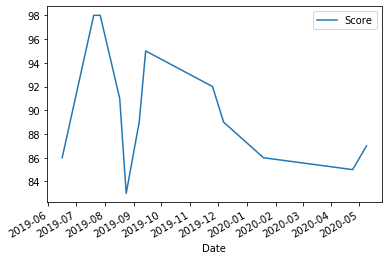

In [51]:
# Scores plotted over time
scores_summary[scores_summary["Holes Played"] == 18].plot(x="Date", y="Score")

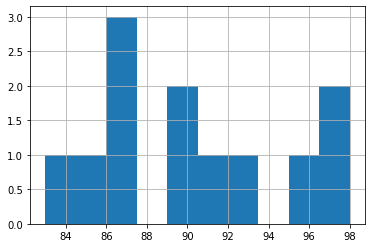

In [52]:
# Distribution of scores
scores_summary[scores_summary["Holes Played"] == 18]['Score'].hist()

In [53]:
# Function to find the average of stats given a specific range of scores.

def find_stats(input_score):
    df = scores_summary[(scores_summary["Score"] > input_score) & (scores_summary["Score"] < input_score + 10) & (scores_summary["Holes Played"] == 18)]
    df = pd.DataFrame(df[['Putts','Fairways','GIR']].mean())
    df.columns = [str(input_score) + 's']
    return df

In [54]:
# Find the average stats for all scores in ranges 80-90 and 90-100

shoot_80s = find_stats(input_score = 80)
shoot_90s = find_stats(input_score = 90)
shoot_80s.merge(shoot_90s, left_index=True, right_index = True)

,80s,90s
Putts,30.571429,33.8
Fairways,5.857143,6.2
GIR,4.000000,3.0


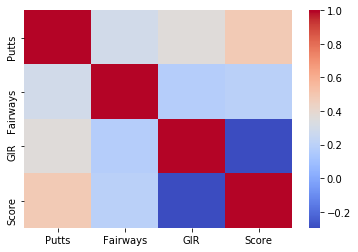

In [55]:
# What stats are most highly correlated with score?
correlations = scores_summary[["Putts", "Fairways", "GIR", "Score"]].corr()
sns.heatmap(correlations, cmap='coolwarm')

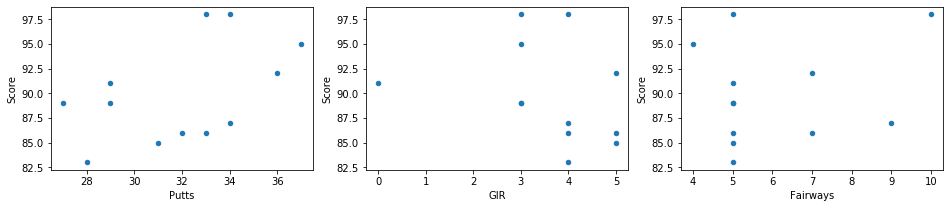

In [56]:
# Show the relationship between each stat and the score using a scatterplot
fig, axs = plt.subplots(1, 3, sharey=False)
scores_summary[scores_summary["Holes Played"] == 18].plot(kind="scatter", x="Putts", y="Score", ax=axs[0], figsize=(16, 3))
scores_summary[scores_summary["Holes Played"] == 18].plot(kind="scatter", x="GIR", y="Score", ax=axs[1], figsize=(16, 3))
scores_summary[scores_summary["Holes Played"] == 18].plot(kind="scatter", x="Fairways", y="Score", ax=axs[2], figsize=(16, 3))

### PGA Tour Data

Using a publically available dataset with the stats and average scores for professional golfers could be a way of expanding my dataset. Each record in this PGA Tour dataset represents a player and a summary of statistics for all the rounds they played between 2010 and 2018.

In [8]:
# Import PGA Tour Data
data = pd.read_csv('./data/pgaTourData.csv')

In [9]:
# Remove NA records.
cleaned_data = data[data['gir'].notna()]

# Remove unecessary features
cleaned_data = cleaned_data[['gir','Average Putts','Average Score','Fairway Percentage']]

# Convert average percentages per round into averages totals per round 
cleaned_data['gir'] = (cleaned_data['gir']/100)*18
cleaned_data['Fairway Percentage'] = (cleaned_data['Fairway Percentage']/100)*14

# Rename columns
cleaned_data.columns = ['Greens','Putts','Score','Fairways']
cleaned_data

,Greens,Putts,Score,Fairways
0,13.2318,29.93,69.617,10.5266
1,12.2796,29.31,70.758,10.3012
2,12.3606,29.12,70.432,10.1136
3,12.3840,29.17,70.015,10.0716
4,12.0816,29.11,71.038,10.0016
...,...,...,...,...
1673,11.7234,28.79,69.966,7.3724
1674,11.8188,29.78,71.697,7.3094
1675,11.8584,29.14,70.953,7.1806
1676,11.0952,28.88,72.194,7.1778


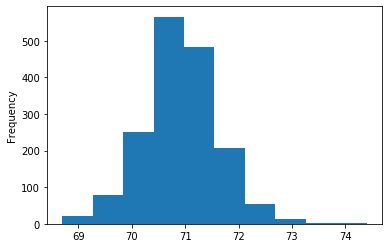

In [10]:
# Distrubution of the average scores for all 2312 players in the dataset
cleaned_data['Score'].plot(kind='hist')

In [12]:
# Function to find the average of stats given a specific score.

def find_avg_stats(score):
    stats = cleaned_data[(cleaned_data['Score'] >= score) & (cleaned_data['Score'] < (score+1))].mean()
    return stats.rename(score)

attributes = pd.DataFrame()
for i in range(69,73):
    stats = find_avg_stats(i)
    attributes = attributes.append(stats)
    
attributes

,Fairways,Greens,Putts,Score
69,8.668312,12.181105,28.902197,69.676947
70,8.689830,11.945433,29.111790,70.601705
71,8.527404,11.660652,29.246195,71.385104
72,8.320646,11.344292,29.486923,72.297560
